In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/1_code/')
from func import set_proj_env, my_get_cmap, rank_int

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125 250
_ = set_proj_env(exclude_str = exclude_str, parc_str = parc_str, parc_scale = parc_scale)

In [4]:
# output file prefix
outfile_prefix = exclude_str+'_'
outfile_prefix

'fsFinalExclude_'

### Setup directory variables

In [5]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline


In [6]:
outputdir = os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/2_pipeline/0_get_sample/out


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/normative_neurodev_cs_t1/3_output/figs


# Load in demographic and symptom data

In [8]:
# LTN and Health Status
health = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/health/n1601_health_20170421.csv'))
# Protocol
prot = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/n1601_pnc_protocol_validation_params_status_20161220.csv'))
# T1 QA
t1_qa = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_t1QaData_20170306.csv'))
# Demographics
demog = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/demographics/n1601_demographics_go1_20161212.csv'))
# Brain volume
brain_vol = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_ctVol20170412.csv'))

# GOASSESS Bifactor scores
goassess = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/GO1_clinical_factor_scores_psychosis_split_BIFACTOR.csv'))
# Clinical diagnostic 
clinical = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/clinical/n1601_goassess_psych_summary_vars_20131014.csv'))
# Psychosis summary
clinical_psychosis = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/clinical/n1601_diagnosis_dxpmr_20170509.csv'))

# merge
df = health
df = pd.merge(df, prot, on=['scanid', 'bblid']) # prot
df = pd.merge(df, t1_qa, on=['scanid', 'bblid']) # t1_qa
df = pd.merge(df, demog, on=['scanid', 'bblid']) # demog
df = pd.merge(df, brain_vol, on=['scanid', 'bblid']) # brain_vol
df = pd.merge(df, clinical, on=['scanid', 'bblid']) # clinical
df = pd.merge(df, clinical_psychosis, on=['scanid', 'bblid']) # clinical
df = pd.merge(df, goassess, on=['bblid']) # goassess

print(df.shape[0])
df.set_index(['bblid', 'scanid'], inplace = True)

1599


In [9]:
df.head()

,,timepoint_x,smrytrt_psychinpt,psychoactiveMedPsychv2,psychoactiveMedMedicalv2,incidentalFindingExclude,medicalratingExcludev1,healthExcludev2,ltnExcludev2,squeakycleanExclude,psychoactiveMedMedical,...,goassessDxpmr4,goassessDxpmSep15,goassessDxpmr6,goassessDxpmr7,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
80961,2632,1,0,1,0,0,0,0,1,1,0,...,4PS,PS,PS,PS,1.946241,1.250946,1.375173,-0.737588,0.845164,-2.437746
80199,2637,1,0,0,0,0,0,0,0,0,0,...,3PC,Healthy,TD,PS,1.854055,0.370510,-0.925523,-0.883597,0.130829,0.742890
80179,2643,1,1,1,0,0,0,0,1,1,0,...,3PC,NaN,TD,TD,0.495788,-0.824844,1.762409,1.037908,0.622578,0.950200
81005,2644,1,0,0,0,0,1,1,1,1,0,...,1TD,NaN,TD,TD,0.059965,-1.015043,1.395996,0.373101,1.358093,0.982293
80812,2646,1,0,0,0,0,0,0,0,1,0,...,4PS,PS,PS,PS,2.080370,0.274750,-1.888498,0.261131,-1.500084,1.584978


# Filter subjects

In [10]:
# 1) Primary sample filter
df = df[df['healthExcludev2'] == 0]
print('N after initial exclusion:', df.shape[0])

# 2) T1 exclusion
df = df[df[exclude_str] == 0]
print('N after T1 exclusion:', df.shape[0])

N after initial exclusion: 1445
N after T1 exclusion: 1382


In [11]:
# 3) filter subjects with NaN on key variables
screen = [train_test_str, 'ageAtScan1', 'sex', 'race2', 'handednessv2', 'medu1', 'mprage_antsCT_vol_TBV', 'averageManualRating',
          'Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']

drop_idx = df.loc[:,screen].isna().any(axis = 1)
df = df.loc[~drop_idx,:]
print('N after variable screen:', df.shape[0])

N after variable screen: 1365


In [12]:
df['averageManualRating'].unique()

array([2.   , 1.667, 1.333, 1.   ])

In [13]:
np.sum(df['averageManualRating'] == 2)

1128

In [14]:
# Convert age to years
df['ageAtScan1_Years'] = np.round(df.ageAtScan1/12, decimals=1)

# Define train/test split

In [15]:
if train_test_str == 'squeakycleanExclude':
    # 1) Use squeakycleanExclude
    # For PNC, the train/test split is based upon the 'squeakycleanExclude' criteria. From the wiki:
    # "This category excludes all subjects with any screening diagnosis as found by the GOASSESS clinical screening instrument.
    # Note that this is NOT a commonly used criteria except for sensitivity analysis, and in general we would prefer to not
    # have studies use this without a strong rationale; would discuss with your BBL liaison."
    # train = squeakycleanExclude == 0 --> retain those WITHOUT any lifetime psychopathology 
    # test = squeakycleanExclude == 1 --> retain those WITH lifetime psychopathology
    print('Train:', np.sum(df[train_test_str] == 0), 'Test:', np.sum(df[train_test_str] == 1))

    # randomly sample a healthy holdout cohort
    df['train_test'] = df[train_test_str]
    n=100
#     n=np.round(df.loc[df[train_test_str] == 0,:].shape[0]*.5).astype(int)
    print(n)
    hold_out = df.loc[df[train_test_str] == 0,:].sample(n=n, random_state=0, replace=False, axis=0).index
    df.loc[hold_out,'train_test'] = 1
    print('Train:', np.sum(df['train_test'] == 0), 'Test:', np.sum(df['train_test'] == 1))

train_test_str = 'train_test'

Train: 402 Test: 963
100
Train: 302 Test: 1063


# Characterise train/test split

## Train/Test split

In [16]:
# find unique ages
age_unique = np.unique(df.ageAtScan1_Years)
print('There are', age_unique.shape[0], 'unique age points')

# Check if train and test represent the full unique age space
train_diff = np.setdiff1d(df[df[train_test_str] == 0].ageAtScan1_Years,age_unique)
test_diff = np.setdiff1d(df[df[train_test_str] == 1].ageAtScan1_Years,age_unique)

if train_diff.size == 0:
    print('All unique age points are represented in the training set')
elif train_diff.size != 0:
    print('All unique age points ARE NOT represented in the training set')
    
if test_diff.size == 0:
    print('All unique age points are represented in the testing set')
elif test_diff.size != 0:
    print('All unique age points ARE NOT represented in the testing set')

There are 149 unique age points
All unique age points are represented in the training set
All unique age points are represented in the testing set


## Export

In [17]:
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
print(phenos)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear']


In [18]:
for pheno in phenos:
    if df.loc[:,pheno].isna().any():
        print('NaN replacement: ', pheno)
        x = np.nanmedian(df.loc[:,pheno])
        df.loc[df.loc[:,pheno].isna(),pheno] = x

In [19]:
# Normalize
rank_r = np.zeros(len(phenos),)

for i, pheno in enumerate(phenos):
    # normalize regional metric
#     x = sp.stats.yeojohnson(df.loc[:,pheno])[0]
    x = rank_int(df.loc[:,pheno])
    # check if rank order is preserved
    rank_r[i] = sp.stats.spearmanr(df.loc[:,pheno],x)[0]
    # store normalized version
    df.loc[:,pheno] = x

print(np.sum(rank_r < 0.99))

0


In [20]:
df.loc[:,phenos].var()

Overall_Psychopathology     0.983031
Psychosis_Positive          0.997518
Psychosis_NegativeDisorg    0.997518
AnxiousMisery               0.997518
Externalizing               0.997513
Fear                        0.997508
dtype: float64

In [21]:
header = ['squeakycleanExclude', 'train_test', 'ageAtScan1', 'ageAtScan1_Years','sex', 'race2', 'handednessv2', 'medu1',
          'mprage_antsCT_vol_TBV', 'averageManualRating',
          'Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
          'goassessSmryMood', 'goassessSmryMan', 'goassessSmryDep', 'goassessSmryEat', 'goassessSmryBul',
          'goassessSmryAno', 'goassessSmryAnx', 'goassessSmryGad', 'goassessSmrySep', 'goassessSmryPhb', 'goassessSmrySoc',
          'goassessSmryPan', 'goassessSmryAgr', 'goassessSmryOcd', 'goassessSmryPtd', 'goassessSmryPsy', 'goassessSmryDel',
          'goassessSmryHal', 'goassessSmryHalAv', 'goassessSmryHalAs', 'goassessSmryHalVh', 'goassessSmryHalOh', 'goassessSmryHalTh',
          'goassessSmryBeh', 'goassessSmryAdd', 'goassessSmryOdd', 'goassessSmryCon', 'goassessSmryPrimePos1', 'goassessSmryPrimeTot',
          'goassessSmryPrimePos2', 'goassessSmryPsychOverallRtg', 'goassessDxpmr4']
df.to_csv(os.path.join(outputdir, outfile_prefix+'df.csv'), columns = header)

# Plots

In [22]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

labels = ['Train', 'Test']
phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
phenos_label = ['Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear']

Figure 2A

/Users/lindenmp/opt/anaconda3/envs/normative_neurodev_cs_t1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lindenmp/opt/anaconda3/envs/normative_neurodev_cs_t1/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


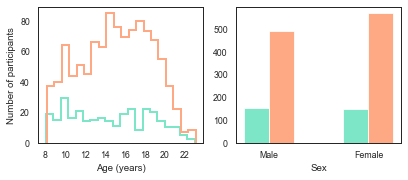

In [23]:
f, axes = plt.subplots(1,2)
f.set_figwidth(6.5)
f.set_figheight(2.5)
colormap = sns.color_palette("pastel", 2)

sns.distplot(df.loc[df[train_test_str] == 0,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[0],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[0]), ax = axes[0]);
sns.distplot(df.loc[df[train_test_str] == 1,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[1],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[1]), ax = axes[0]);
axes[0].set_xlabel('Age (years)');
axes[0].set_ylabel('Number of participants');
axes[0].set_xticks(np.arange(np.min(np.round(age_unique,0)), np.max(np.round(age_unique,0)), 2))

# set width of bar
barWidth = 0.25

# Sex
y_train = [np.sum(df.loc[df[train_test_str] == 0,'sex'] == 1), np.sum(df.loc[df[train_test_str] == 0,'sex'] == 2)]
y_test = [np.sum(df.loc[df[train_test_str] == 1,'sex'] == 1), np.sum(df.loc[df[train_test_str] == 1,'sex'] == 2)]
r1 = np.arange(len(y_train))+barWidth/2
r2 = [x + barWidth for x in r1]
axes[1].bar(r1, y_train, width = barWidth, color = cmap[0], label = labels[0])
axes[1].bar(r2, y_test, width = barWidth, color = cmap[1], label = labels[1])
axes[1].set_xlabel('Sex')
# axes[1].set_ylabel('Number of participants')
axes[1].set_xticks([r + barWidth for r in range(len(y_train))])
axes[1].set_xticklabels(['Male', 'Female'])

f.savefig(outfile_prefix+'age_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Phenotype distributions over train/test

Figure 2B

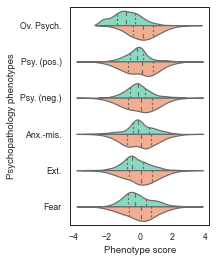

In [24]:
df_rc = pd.melt(df, id_vars = train_test_str, value_vars = phenos)

f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(4)
ax = sns.violinplot(y='variable', x='value', hue=train_test_str, data=df_rc, palette = cmap, split=True, scale='width', inner = 'quartile', orient = 'h')
ax.get_legend().remove()
ax.set_yticklabels(phenos_label_short)
ax.set_ylabel('Psychopathology phenotypes')
ax.set_xlabel('Phenotype score')
f.savefig(outfile_prefix+'phenos_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)